In [2]:
from Functions.fn_spectralanalysis import *
from Functions.fn_basic import read_files, array_to_df, df_channels_to_regions

import os, mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Set the folder of EEG files**

Change these parameters!

*NB! The path has to be in 'Data\Clean\' folder relative to this notebook.*

In [4]:
"""
VARIABLES TO CHANGE
exp_folder: A relative folder location of the experiment (e.g. r"Eyes Closed\Baseline")
exp_condition: A short code of the experiment which will be used for exporting (e.g. r"EC_00")
b_names: A list of bands names
b_freqs: A list of bands' frequency ranges
"""
exp_folder = r"Eyes Closed\Baseline"
exp_condition = r"EC_00"
b_names = ['Delta','Theta','Alpha','Low-Beta','High-Beta']
b_freqs = [[0.5,3],[3.1,6.5],[6.6,12],[12.1,18],[18.1,30]]

**Conduct spectral analysis on clean EEG files and save the results regionally and channel-by-channel in Excel format**

1. Read raw FIF file (cleaned EEG file)
2. Calculate power spectrum density for the current file
3. Calculate bandpower for each frequency band of interest (e.g., delta, theta, alpha, low-beta, high-beta)
4. Plot all the frequency bands topographically
4. Attempt to create a folder and save the bandpowers regionally and channel-by-channel to Excel files

Files in folder: 26


C:\Users\TANIJARV\Downloads\Ketamine-SI project\eeg-pipeline\Functions\fn_spectralanalysis.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


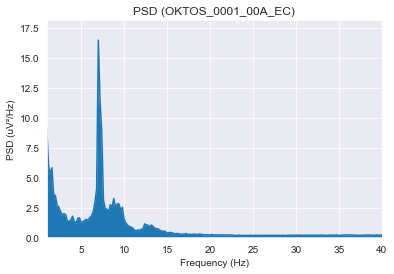

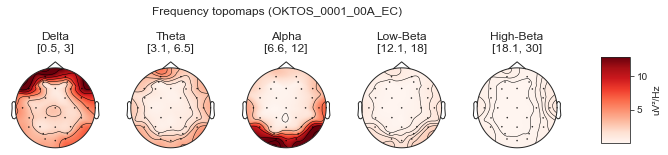

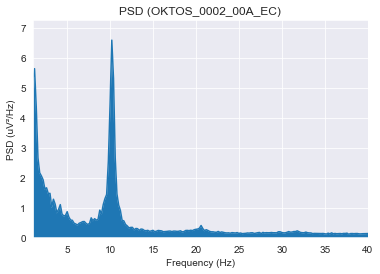

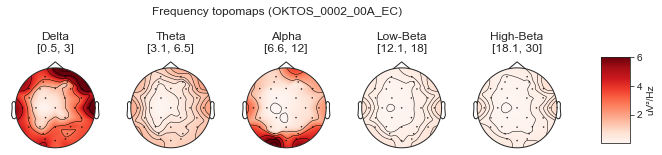

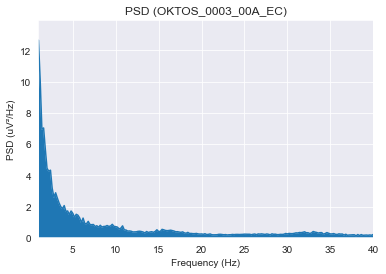

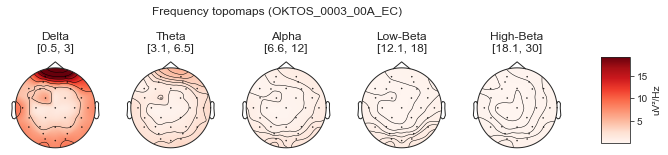

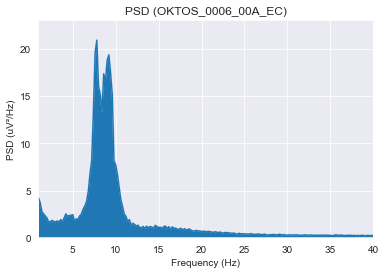

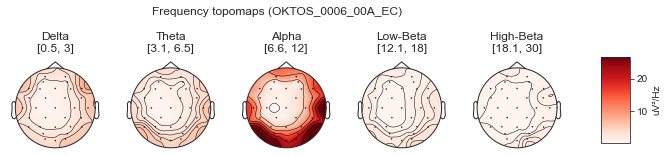

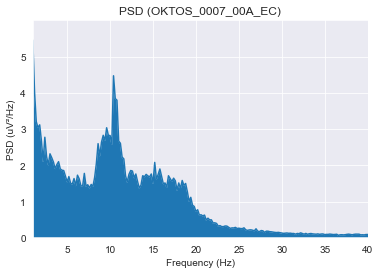

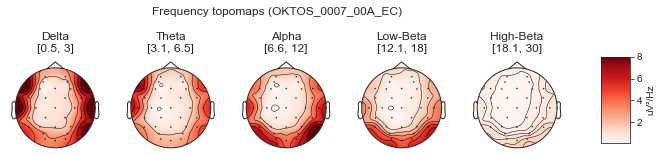

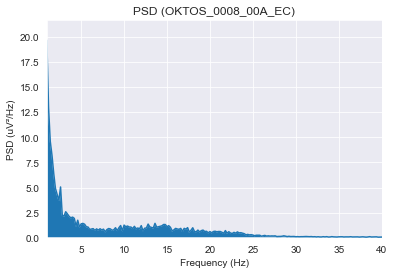

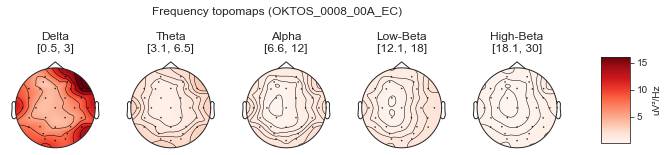

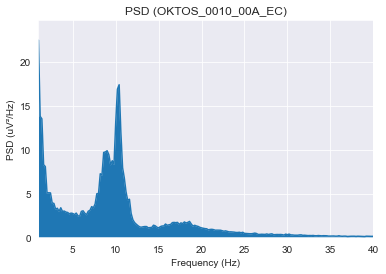

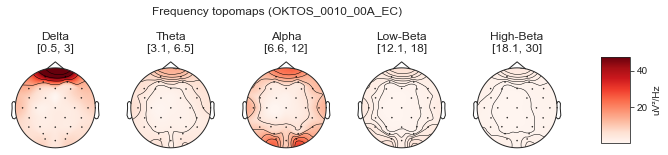

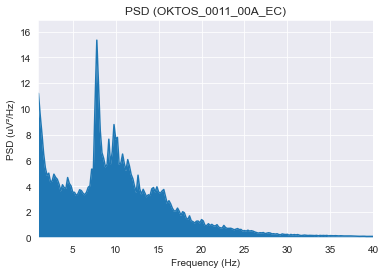

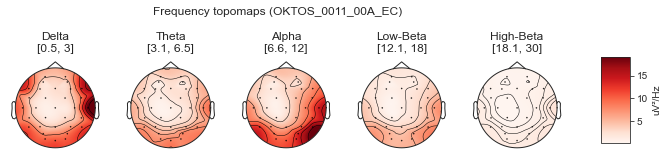

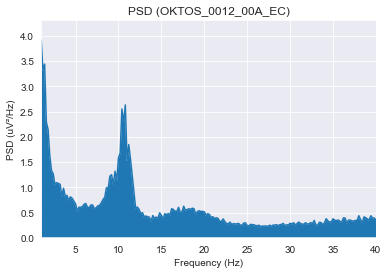

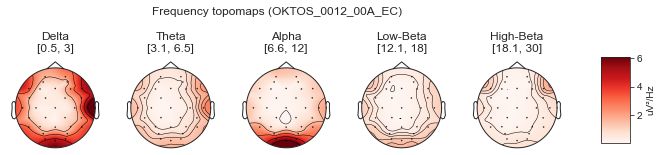

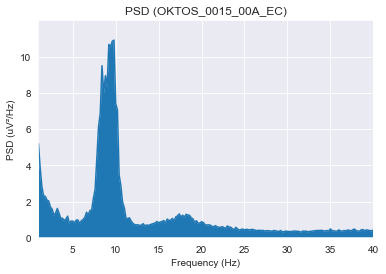

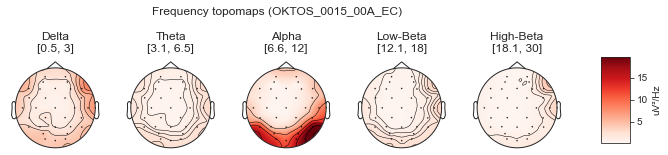

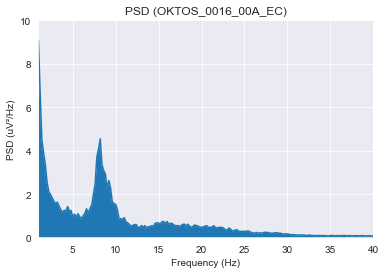

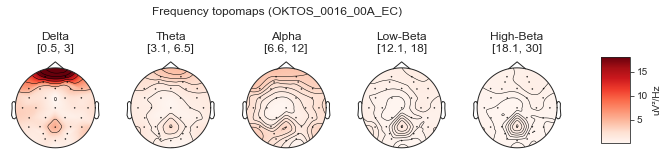

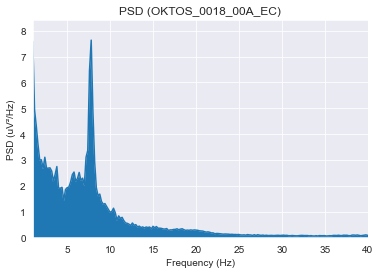

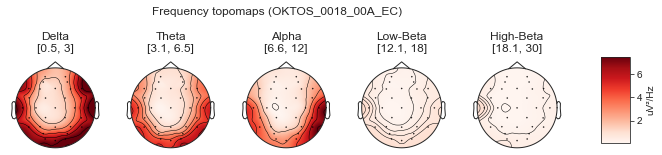

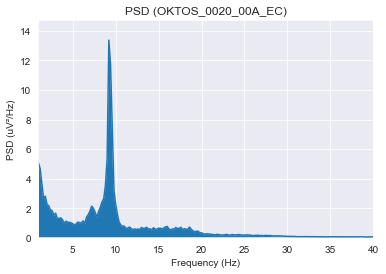

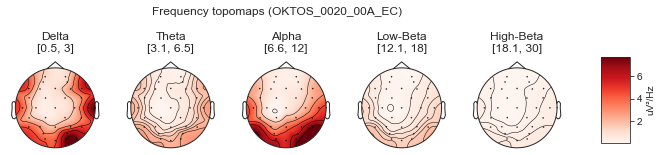

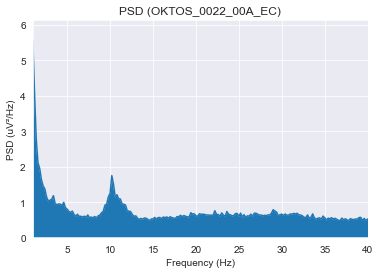

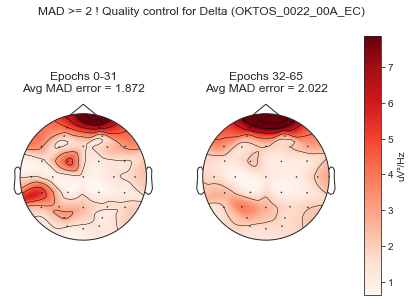

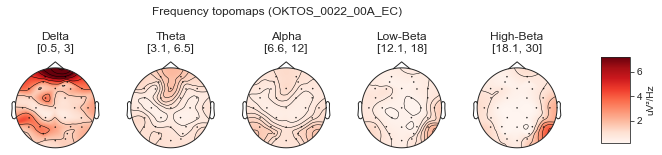

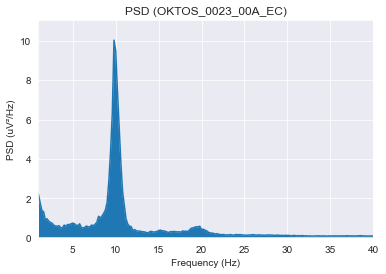

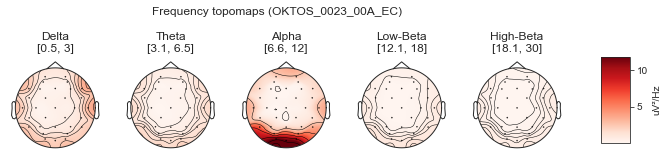

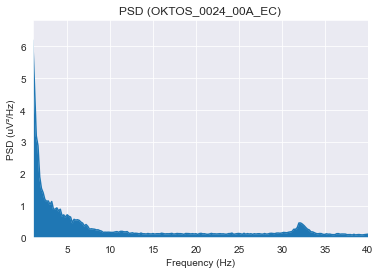

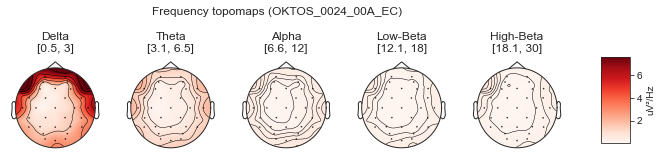

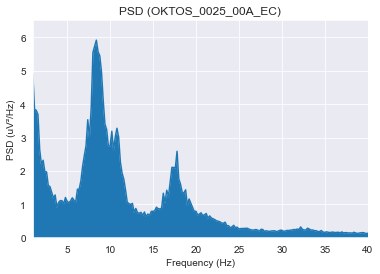

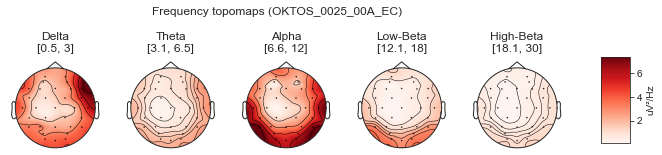

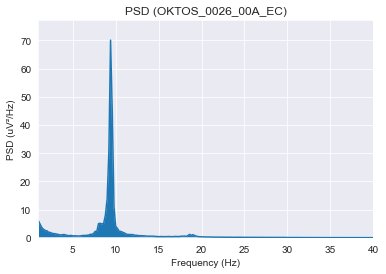

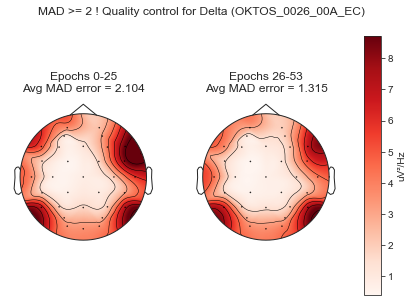

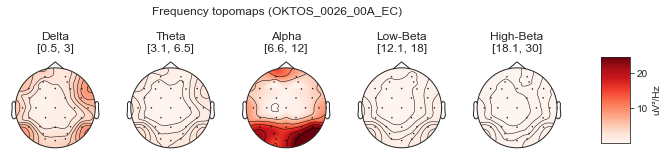

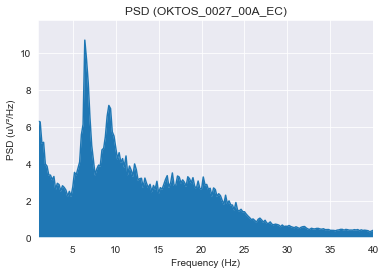

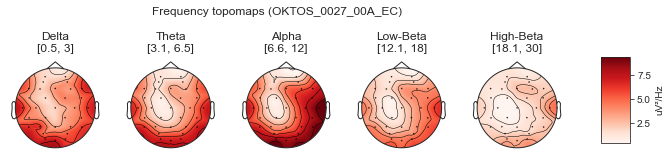

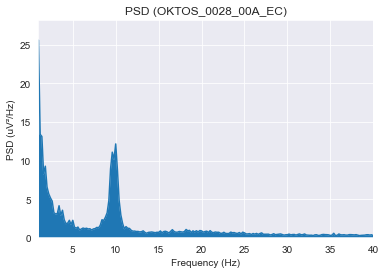

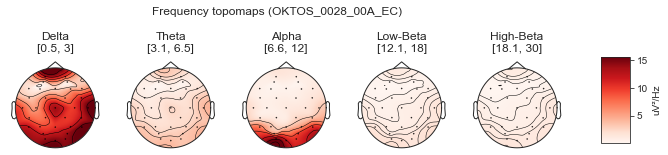

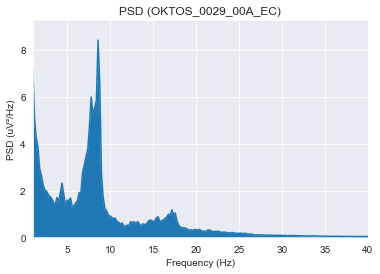

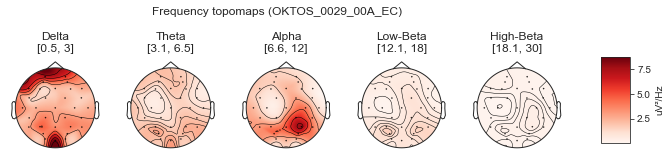

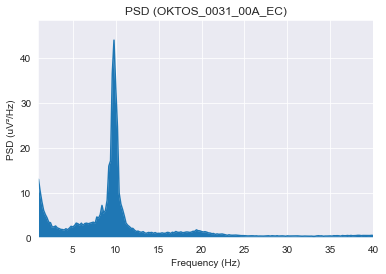

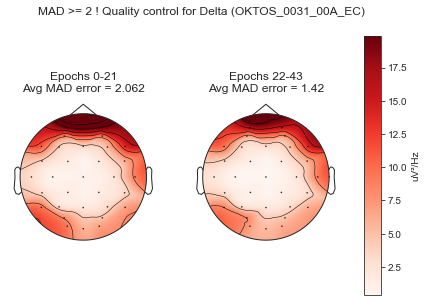

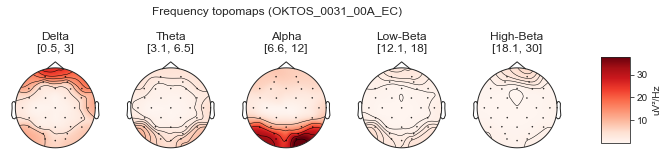

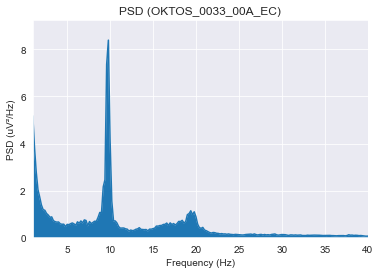

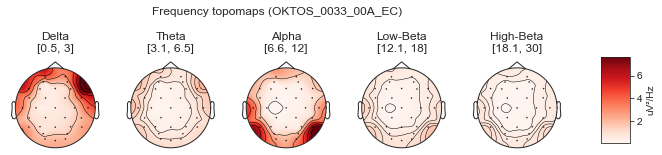

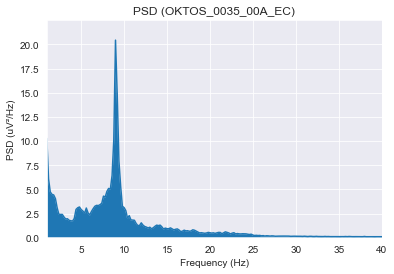

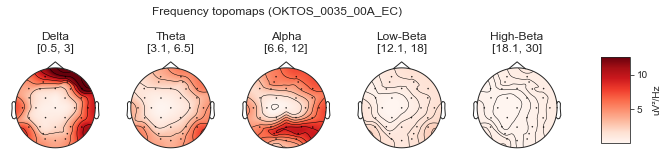

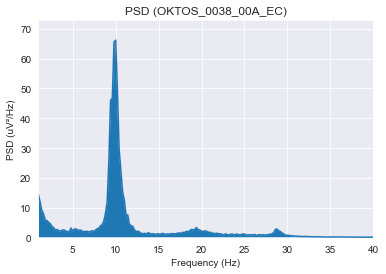

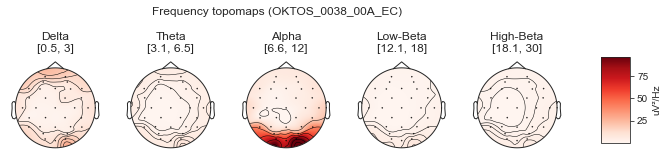

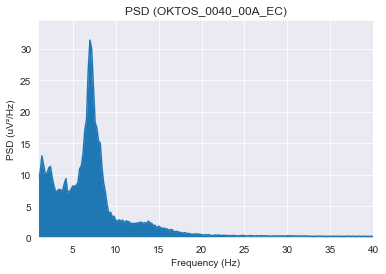

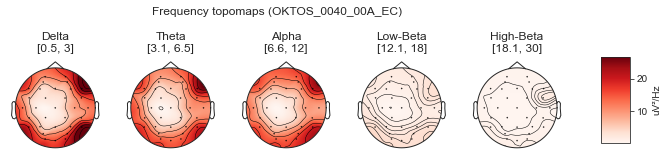

In [6]:
clean_folder = r"Data\Clean"
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = read_files(dir_inprogress,"_clean-epo.fif")
df_faa = pd.DataFrame(columns=['Pre-frontal','Mid-frontal','Lateral-frontal'])

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)
    
    # Calculate Welch's power spectrum density (FFT)
    [psds,freqs] = calculate_psd(epochs,subject_names[i],epo_duration=5)

    # Find power for all bands and add to dataframe including the previous subjects
    vmin = float('inf')
    vmax = 0
    for j in range(len(b_names)):
        if i == 0:
            globals()["df_psd_"+b_names[j]] = pd.DataFrame()
        
        # Devide the PSD to frequency band bins
        globals()["psd_ch_"+b_names[j]] = bandpower_per_channel(psds,freqs,b_freqs[j],b_names[j],subject_names[i],epochs)
        
        # Convert the array to dataframe and concatenate it to dataframe including the previous subjects
        globals()["temp_df_psd_"+b_names[j]] = array_to_df(subject_names[i],epochs,globals()["psd_ch_"+b_names[j]])
        globals()["df_psd_"+b_names[j]] = pd.concat([globals()["df_psd_"+b_names[j]],globals()["temp_df_psd_"+b_names[j]]])
        
        # Save the minimum and maximum PSD values as an integer for later colorbar use
        vmin = min([vmin,min(globals()["psd_ch_"+b_names[j]])])
        vmax = max([vmax,max(globals()["psd_ch_"+b_names[j]])])

    # Plot topomaps for all bands
    sns.set_style("white",{'font.family': ['sans-serif']})
    fig,axs = plt.subplots(nrows=1,ncols=len(b_names),figsize=(10,3))
    fig.suptitle("Frequency topomaps ({})".format(subject_names[i]))
    for topo in range(len(b_names)):
        im,_ = mne.viz.plot_topomap(globals()["psd_ch_"+b_names[topo]],epochs.info,axes=axs[topo],vmin=vmin,vmax=vmax,show=False)
        axs[topo].set_title(b_names[topo]+'\n'+str(b_freqs[topo]))
    cbar_ax = fig.add_axes([0.95,0.35,0.04,0.4])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_ylabel('uV\u00b2/Hz')

#df_faa['Pre-frontal'] = (df_psd_Alpha['Fp1'] - df_psd_Alpha['Fp2'])/(df_psd_Alpha['Fp1'] + df_psd_Alpha['Fp2'])*100
#df_faa['Mid-frontal'] = (df_psd_Alpha['F3'] - df_psd_Alpha['F4'])/(df_psd_Alpha['F3'] + df_psd_Alpha['F4'])*100
#df_faa['Lateral-frontal'] = (df_psd_Alpha['F7'] - df_psd_Alpha['F8'])/(df_psd_Alpha['F7'] + df_psd_Alpha['F8'])*100
df_faa['Pre-frontal'] = np.log(df_psd_Alpha['Fp1'])-np.log(df_psd_Alpha['Fp2'])
df_faa['Mid-frontal'] = np.log(df_psd_Alpha['F3'])-np.log(df_psd_Alpha['F4'])
df_faa['Lateral-frontal'] = np.log(df_psd_Alpha['F7'])-np.log(df_psd_Alpha['F8'])

# Try to pre-create folders for PSD results
try:
    os.makedirs(os.path.join(r"Results\PSD\channels",exp_folder))
except FileExistsError:
    pass
try:
    os.makedirs(os.path.join(r"Results\PSD\regions",exp_folder))
except FileExistsError:
    pass

df_faa.to_excel(r"Results\PSD\{}_frontal_asymmetry.xlsx".format(exp_condition))

for band in b_names:
    # Save the PSD values for each channel for each band in Excel format
    globals()["df_psd_"+band].to_excel(r"Results\PSD\channels\{}\{}_psd_{}.xlsx".format(exp_folder,exp_condition,band))
    
    # Find regional band powers and save them to Excel as well
    globals()["df_psd_reg_"+band] = df_channels_to_regions(globals()["df_psd_"+band])
    globals()["df_psd_reg_"+band].to_excel(r"Results\PSD\regions\{}\{}_psd_{}.xlsx".format(exp_folder,exp_condition,band))
